In [73]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Overview

## Predictors

There are 10 features

- longitude
- latitude
- housing_median_age
- total_rooms
- total_bedrooms
- population
- households
- median_income
- median_house_value
- ocean_proximity



## Task

- Predict a district's median housing price given the other data about the district


# Load the Data

In [74]:
import os 
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("data", "housing")

def fetch_housing_data(data_url=HOUSING_URL, data_path=HOUSING_PATH):
    # create directory if not exits
    if not os.path.isdir(data_path):
        os.makedirs(data_path)

    # fetch data
    tgz_path = os.path.join(data_path, 'housing.tgz')
    urllib.request.urlretrieve(data_url, tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path=data_path)
    data_tgz.close()

fetch_housing_data()

In [75]:
def load_housing_data():    
    csv_path = os.path.join(HOUSING_PATH, 'housing.csv')
    return pd.read_csv(csv_path)


In [76]:
housing = load_housing_data()
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [77]:
housing.shape


(20640, 10)

In [78]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [79]:
housing.describe() # null values are ignored.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [80]:
housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

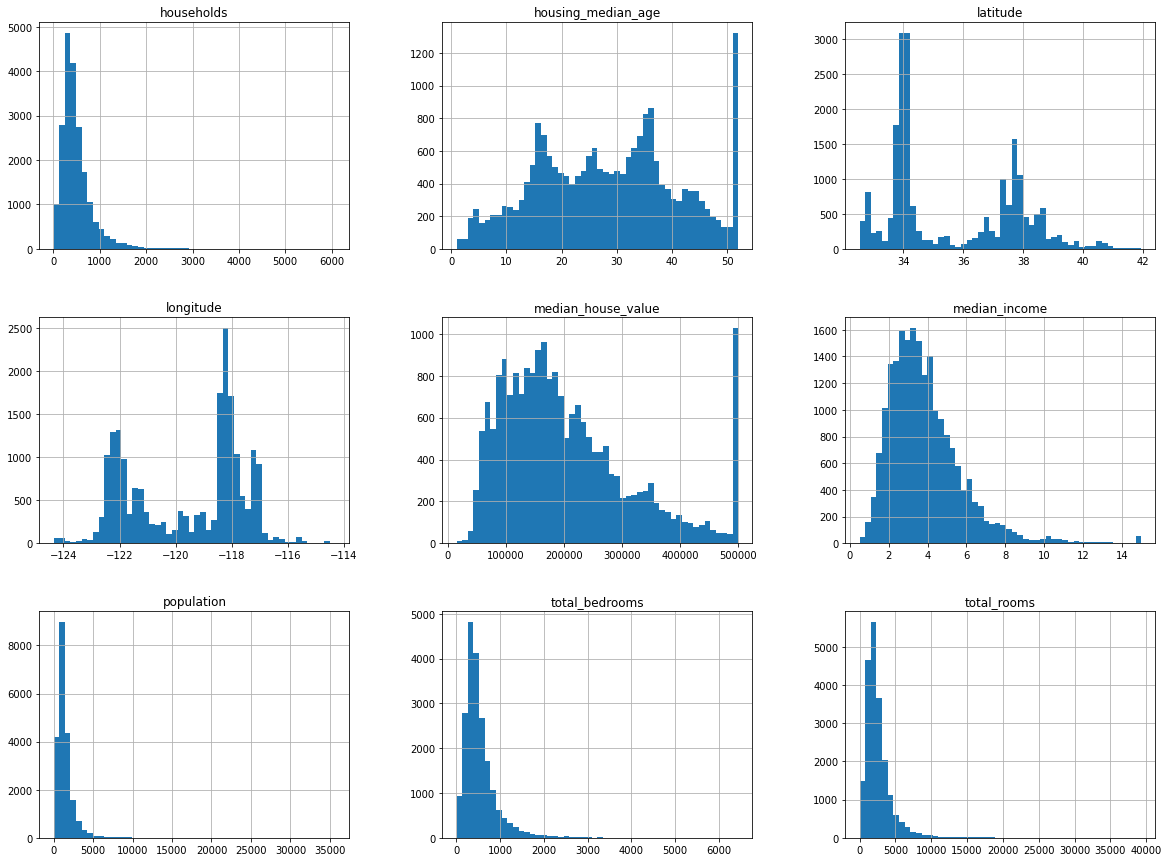

In [81]:
housing.hist(bins=50, figsize=(20, 15))

plt.show()


median_income, median_house_value, housing median age were capped.

- median_income: capped at 15 for higher incomes, and 0.5 fore lower values.

- median_house_value: this is learning target, so it could be a problem that prices would never go over 500,000. If we need precise predictions even beyond this limit,

    - collect data for the districts whose labels were capped

    - remove those districts

These variables have very different scales.

Many histograms are tail-heavy.


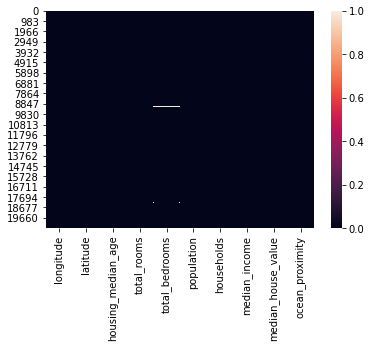

In [82]:
sns.heatmap(housing.isnull())

plt.show()


There are 20640 observations and 10 features. 

Note that the 'total_bedrooms' attribute has 207 null values.

All attributes are numerical except the 'ocean_proximity'.


#  Visualize Data

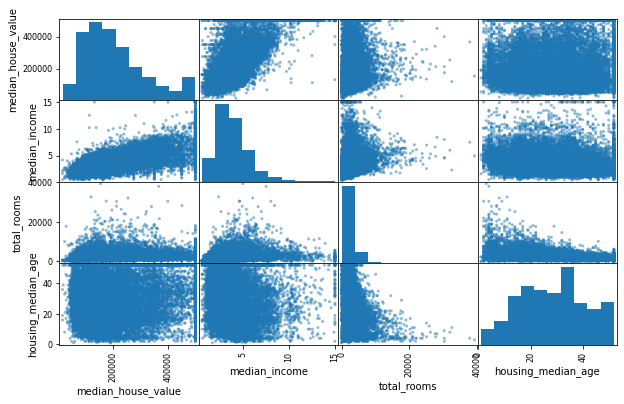

In [83]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(10, 6))

plt.show()


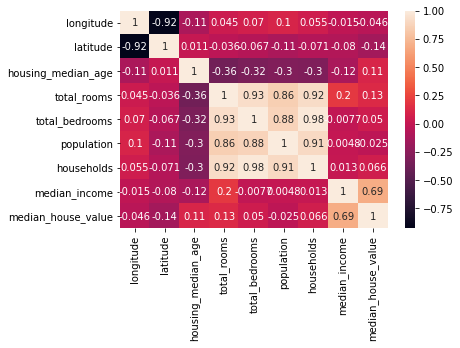

In [84]:

correlation_matrix = housing.corr()

sns.heatmap(correlation_matrix, annot=True)

plt.show()



There is a strong positive correlation between house prices and income
- which means the median house prices tends to go up when the income increases.

There is a slight negative correlation between house prices and latitude
- the prices will go down when you go north


# Prepare the Data for ML

In [144]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

train_set.shape, test_set.shape,


((16512, 10), (4128, 10))

In [145]:
X_train = train_set.drop('median_house_value', axis=1)

y_train = train_set['median_house_value']

X_train.shape, y_train.shape


((16512, 9), (16512,))

In [146]:
X_test = test_set.drop('median_house_value', axis=1)

y_test = test_set['median_house_value']

X_test.shape, y_test.shape


((4128, 9), (4128,))

## Missing Values

"""
Several options:
- remove the observation
- fill the value with some values( mean, median, mode, 0, min, max...)
- remove the corresponding attribute
"""

In [92]:
some_null_rows = X_train[X_train.isnull().any(axis=1)].head()

some_null_rows


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [93]:
# option 1
some_null_rows.dropna(subset=['total_bedrooms'])


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [94]:
# option 2
some_null_rows.drop('total_bedrooms', axis=1)


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity


In [32]:
# option 3

mean_bedrooms = X_train['total_bedrooms'].mean()

print('mean bedrooms: ', mean_bedrooms)

some_null_rows['total_bedrooms'] = some_null_rows['total_bedrooms'].fillna(mean_bedrooms)

some_null_rows


mean bedrooms:  537.8705525375618


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
290,-122.16,37.77,47.0,1256.0,537.870553,570.0,218.0,4.3750,NEAR BAY
341,-122.17,37.75,38.0,992.0,537.870553,732.0,259.0,1.6196,NEAR BAY
538,-122.28,37.78,29.0,5154.0,537.870553,3741.0,1273.0,2.5762,NEAR BAY
563,-122.24,37.75,45.0,891.0,537.870553,384.0,146.0,4.9489,NEAR BAY
696,-122.10,37.69,41.0,746.0,537.870553,387.0,161.0,3.9063,NEAR BAY


In [38]:
# option 3: using sklearn
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_without_ocean_cate = X_train.drop('ocean_proximity', axis=1)
imputed_housing = imputer.fit_transform(housing_without_ocean_cate) # plain numpy array
imputed_housing_df = pd.DataFrame(imputed_housing, columns=housing_without_ocean_cate.columns,
                          index=housing_x.index)

imputed_housing_df.shape

(20640, 8)

## Categorical Variables

In [40]:
housing_cat = X_train[['ocean_proximity']]

housing_cat.head()


,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


### Option 1: To numbers

In [41]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:-10]


array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

In [42]:
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Option 2: 1-of-K

In [43]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
housing_one_hot_encoder = one_hot_encoder.fit_transform(housing_cat)
housing_one_hot_encoder


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [44]:
one_hot_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household =  X[:, rooms_ix] / X[:, households_ix]
        
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        return np.c_[X, rooms_per_household, population_per_household]


In [46]:
attr_adder = CombinedAttributesAdder()
                   
housing_extra_attribs = pd.DataFrame(
    attr_adder.transform(X_train.values),
    columns=list(housing_x.columns) + ["rooms_per_household",'population_per_household'],    
    index=X_train.index
)

housing_extra_attribs.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,6.98413,2.55556
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,6.23814,2.10984
2,-122.24,37.85,52,1467,190,496,177,7.2574,NEAR BAY,8.28814,2.80226
3,-122.25,37.85,52,1274,235,558,219,5.6431,NEAR BAY,5.81735,2.54795
4,-122.25,37.85,52,1627,280,565,259,3.8462,NEAR BAY,6.28185,2.18147


## Feature Scaling

In [ ]:
"""
- min-max normalization

- standardization

"""

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X_train_num = X_train.drop("ocean_proximity", axis=1)


In [48]:

mul_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
    
])
                   
housing_extra_attribs = pd.DataFrame(
    mul_pipeline.fit_transform(X_train_num),
    columns=list(housing_without_ocean_cate.columns)+["rooms_per_household",'population_per_household'],    
    index=X_train_num.index
)

housing_extra_attribs.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.628559,-0.049597
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.327041,-0.092512
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.155620,-0.025843
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.156966,-0.050329
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.344711,-0.085616


In [49]:
# compare with the original data
X_train_num.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


## Column Transformer

In [147]:
from sklearn.compose import ColumnTransformer

X_train_num = X_train.drop("ocean_proximity", axis=1)
num_attribs = list(X_train_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", mul_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_pre = full_pipeline.fit_transform(X_train)


X_train_pre = pd.DataFrame(
    X_train_pre,
    columns=num_attribs + ["rooms_per_household",'population_per_household', '1HOCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],    
    index=X_train.index
)

print(X_train_pre.shape, y_train.shape)

X_train_pre.iloc[[1, 4490, 1220, 9020, 9900]]



(16512, 15) (16512,)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,1HOCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
8267,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843,-0.402835,-0.117362,0.0,0.0,0.0,0.0,1.0
10080,-0.327938,1.734929,-1.635303,0.714158,0.445121,-0.998620,-1.010580,-0.210874,13.003390,-0.048930,0.0,1.0,0.0,0.0,0.0
8877,0.544622,-0.750327,1.538766,-0.120025,-0.461812,-0.499070,-0.509210,2.176697,0.982620,-0.025027,1.0,0.0,0.0,0.0,0.0
4597,0.649329,-0.745647,0.983304,-0.720601,0.139628,0.733097,0.299281,-1.355270,-1.543340,0.050423,1.0,0.0,0.0,0.0,0.0
15091,1.322447,-1.330688,-0.762434,-0.356393,-0.001186,-0.182453,-0.083965,-0.951696,-0.605671,-0.042515,1.0,0.0,0.0,0.0,0.0


# Learning a Model

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train_pre, y_train)

y_train_predicted = lin_reg.predict(X_train_pre)

np.sqrt(mean_squared_error(y_train, y_train_predicted))


68329.87371986113

In [149]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_pre, y_train)

y_train_predicted = tree_reg.predict(X_train_pre)
np.sqrt(mean_squared_error(y_train, y_train_predicted))


0.0

In [150]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_train_pre, y_train)

y_train_predicted = tree_reg.predict(X_train_pre)
np.sqrt(mean_squared_error(y_train, y_train_predicted))


0.0

# Evaluation

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [121]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train_pre, y_train, scoring='neg_mean_squared_error', cv=10)
tree_scores = np.sqrt(-scores)
display_scores(tree_scores)


Scores: [65694.14888508 68834.86575497 70484.62299266 70769.3135473
 71073.91863598 68166.60118904 68419.27570313 70742.56927404
 68795.8405164  73597.09140664]
Mean: 69657.82479052352
Standard deviation: 2037.3407468548849


In [122]:
scores = cross_val_score(lin_reg, X_train_pre, y_train, scoring='neg_mean_squared_error', cv=10)
lin_scores = np.sqrt(-scores)
display_scores(lin_scores)


Scores: [65601.01689098 71627.20418119 68038.38722887 66987.28199265
 69394.1236065  66115.0624049  65908.87195323 69281.69706496
 72885.82145152 69751.44015401]
Mean: 68559.09069288042
Standard deviation: 2350.827631996557


the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [124]:
scores = cross_val_score(forest_reg, X_train_pre, y_train, scoring='neg_mean_squared_error', cv=10)
lin_scores = np.sqrt(-scores)
display_scores(lin_scores)


Scores: [47015.34966853 51194.62416512 49669.83910887 51597.82580661
 52733.37901531 47081.75580903 47538.93089953 50967.70805006
 49652.06291446 50227.86413784]
Mean: 49767.93395753696
Standard deviation: 1887.129667151052


# GridSearchCV

In [157]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [4, 6]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_pre, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [4, 6],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [160]:
grid_search.best_params_


{'max_features': 6, 'n_estimators': 30}

In [161]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

59173.18426186042 {'max_features': 4, 'n_estimators': 3}
52780.085396702365 {'max_features': 4, 'n_estimators': 10}
50337.70338672644 {'max_features': 4, 'n_estimators': 30}
57770.832396035476 {'max_features': 6, 'n_estimators': 3}
51724.35404414309 {'max_features': 6, 'n_estimators': 10}
49428.42468956774 {'max_features': 6, 'n_estimators': 30}
57807.53704432193 {'max_features': 8, 'n_estimators': 3}
52010.72605581494 {'max_features': 8, 'n_estimators': 10}
50107.955676158825 {'max_features': 8, 'n_estimators': 30}
58056.33952043079 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51794.152238481154 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
56312.51381840923 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
50930.68348799908 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}


In [162]:
final_model = grid_search.best_estimator_



In [163]:
feature_importances = final_model.feature_importances_

sorted(zip(feature_importances, list(X_train_pre)), reverse=True)


[(0.35473676712162544, 'median_income'),
 (0.1392497109958892, 'INLAND'),
 (0.10546558774573284, 'population_per_household'),
 (0.09209902813697124, 'longitude'),
 (0.08111525788932936, 'latitude'),
 (0.08108628792420274, 'rooms_per_household'),
 (0.0411733844487989, 'housing_median_age'),
 (0.019308263162841587, 'population'),
 (0.019113944650424822, 'total_rooms'),
 (0.018568247598962057, 'total_bedrooms'),
 (0.017237900860317373, '1HOCEAN'),
 (0.016752133575571065, 'households'),
 (0.007097468482913015, 'NEAR BAY'),
 (0.006827657682804671, 'NEAR OCEAN'),
 (0.0001683597236155986, 'ISLAND')]

In [164]:
from sklearn.compose import ColumnTransformer

X_test_num = X_test.drop("ocean_proximity", axis=1)
num_attribs = list(X_test_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", mul_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_test_pre = full_pipeline.fit_transform(X_test)

X_test_pre = pd.DataFrame(
    X_test_pre,
    columns=num_attribs + ["rooms_per_household",'population_per_household', '1HOCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],    
    index=X_test.index
)


In [165]:
y_test_predicted = final_model.predict(X_test_pre)

np.sqrt(mean_squared_error(y_test, y_test_predicted))


66497.99208159636